# GameTheory 21b - Jeux Cooperatifs Lean (Python)

**Kernel** : Python 3

**Navigation** : [← GameTheory-21-Lean-CooperativeGames](GameTheory-21-Lean-CooperativeGames.ipynb) | [Index](GameTheory-1-Setup.ipynb) | [Fin de la serie]

---

## Introduction

Ce notebook compagnon du **notebook 21 (Lean)** fournit les **illustrations Python** des concepts formalises :

- Jeu de gants (Glove Game) et calcul de Shapley
- Verification du Core vide pour les jeux de majorite
- Jeux de vote ponderes et indice de Banzhaf

Pour les implementations completes de Shapley et Core, voir le notebook 14.

### Duree estimee : 25 minutes

In [1]:
# Configuration
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from math import factorial
from collections import defaultdict

print("Notebook Python compagnon pour les jeux cooperatifs (Lean)")

Notebook Python compagnon pour les jeux cooperatifs (Lean)


---

## 1. Valeur de Shapley - Rappels

La valeur de Shapley est la contribution marginale moyenne d'un joueur sur toutes les permutations :

$$\phi_i(v) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(n-|S|-1)!}{n!} [v(S \cup \{i\}) - v(S)]$$

In [2]:
def shapley_value_exact(v, n):
    """Calcul exact de la valeur de Shapley.
    
    Args:
        v: Fonction caracteristique v(S) ou S est un frozenset
        n: Nombre de joueurs
    
    Returns:
        Liste des valeurs de Shapley pour chaque joueur
    """
    shapley = [0.0] * n
    
    for perm in permutations(range(n)):
        coalition = set()
        for i in perm:
            marginal = v(frozenset(coalition | {i})) - v(frozenset(coalition))
            shapley[i] += marginal
            coalition.add(i)
    
    return [s / factorial(n) for s in shapley]

print("Fonction shapley_value_exact definie.")

Fonction shapley_value_exact definie.


---

## 2. Jeu de Gants (Glove Game)

**Exercice 1 du notebook 21 Lean** : Trois joueurs L1, L2 ont chacun un gant gauche, R1 a un gant droit. Une paire de gants vaut 1.

In [3]:
# Jeu de gants : L1=0, L2=1, R1=2
def glove_game(coalition):
    """Fonction caracteristique du jeu de gants.
    Joueurs 0,1 ont des gants gauches, joueur 2 a un gant droit.
    Valeur = nombre de paires completes.
    """
    left_gloves = sum(1 for i in coalition if i in {0, 1})
    right_gloves = sum(1 for i in coalition if i == 2)
    return min(left_gloves, right_gloves)

# Verification de la fonction caracteristique
print("JEU DE GANTS")
print("=" * 40)
print("Joueurs : L1=0, L2=1 (gants gauches), R1=2 (gant droit)")
print("\nFonction caracteristique :")

all_coalitions = [frozenset(c) for r in range(4) for c in combinations(range(3), r)]
for S in sorted(all_coalitions, key=lambda x: (len(x), tuple(sorted(x)))):
    labels = {0: 'L1', 1: 'L2', 2: 'R1'}
    coalition_str = '{' + ', '.join(labels[i] for i in sorted(S)) + '}' if S else '{}'
    print(f"  v({coalition_str}) = {glove_game(S)}")

JEU DE GANTS
Joueurs : L1=0, L2=1 (gants gauches), R1=2 (gant droit)

Fonction caracteristique :
  v({}) = 0
  v({L1}) = 0
  v({L2}) = 0
  v({R1}) = 0
  v({L1, L2}) = 0
  v({L1, R1}) = 1
  v({L2, R1}) = 1
  v({L1, L2, R1}) = 1


In [4]:
# Calcul de Shapley pour le jeu de gants
shapley_glove = shapley_value_exact(glove_game, 3)

print("\nVALEURS DE SHAPLEY :")
labels = ['L1 (gant gauche)', 'L2 (gant gauche)', 'R1 (gant droit)']
for i, (label, val) in enumerate(zip(labels, shapley_glove)):
    print(f"  {label}: {val:.4f} = {int(val*6)}/6")

print(f"\nTotal : {sum(shapley_glove):.4f} (= v(N) = 1)")

print("\nInterpretation :")
print("  - R1 (gant droit) a une valeur de 2/3 car il possede la ressource rare")
print("  - L1 et L2 se partagent 1/3 car ils sont en competition")


VALEURS DE SHAPLEY :
  L1 (gant gauche): 0.1667 = 1/6
  L2 (gant gauche): 0.1667 = 1/6
  R1 (gant droit): 0.6667 = 4/6

Total : 1.0000 (= v(N) = 1)

Interpretation :
  - R1 (gant droit) a une valeur de 2/3 car il possede la ressource rare
  - L1 et L2 se partagent 1/3 car ils sont en competition


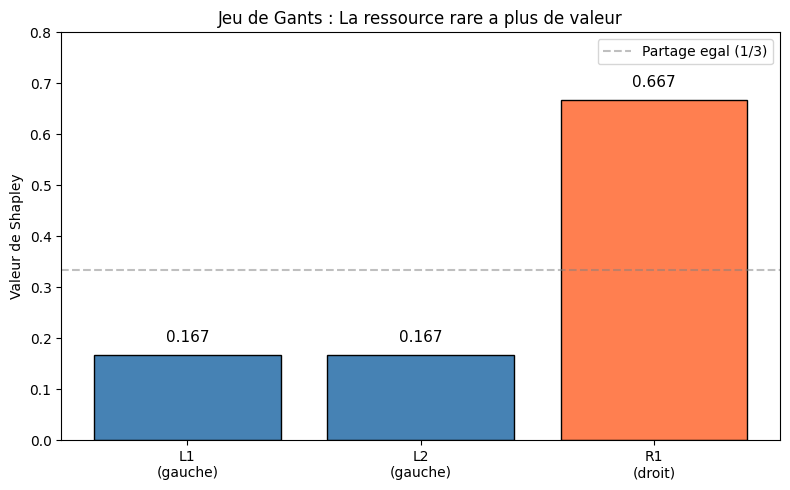

In [5]:
# Visualisation
fig, ax = plt.subplots(figsize=(8, 5))

players = ['L1\n(gauche)', 'L2\n(gauche)', 'R1\n(droit)']
colors = ['steelblue', 'steelblue', 'coral']

bars = ax.bar(players, shapley_glove, color=colors, edgecolor='black')

# Ajouter les valeurs sur les barres
for bar, val in zip(bars, shapley_glove):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Valeur de Shapley')
ax.set_title('Jeu de Gants : La ressource rare a plus de valeur')
ax.set_ylim(0, 0.8)
ax.axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Partage egal (1/3)')
ax.legend()

plt.tight_layout()
plt.show()

---

## 3. Core Vide : Jeu de Majorite

**Exercice 3 du notebook 21 Lean** : Montrer que le jeu de majorite simple a 3 joueurs a un Core vide.

In [6]:
def majority_game_3(coalition):
    """Jeu de majorite simple a 3 joueurs.
    v(S) = 1 si |S| >= 2, 0 sinon.
    """
    return 1 if len(coalition) >= 2 else 0

print("JEU DE MAJORITE SIMPLE A 3 JOUEURS")
print("=" * 50)

print("\nFonction caracteristique :")
for S in sorted(all_coalitions, key=lambda x: (len(x), tuple(sorted(x)))):
    coalition_str = '{' + ', '.join(str(i+1) for i in sorted(S)) + '}' if S else '{}'
    print(f"  v({coalition_str}) = {majority_game_3(S)}")

JEU DE MAJORITE SIMPLE A 3 JOUEURS

Fonction caracteristique :
  v({}) = 0
  v({1}) = 0
  v({2}) = 0
  v({3}) = 0
  v({1, 2}) = 1
  v({1, 3}) = 1
  v({2, 3}) = 1
  v({1, 2, 3}) = 1


In [7]:
print("\nPREUVE QUE LE CORE EST VIDE")
print("=" * 50)
print("""
Pour qu'une allocation (x1, x2, x3) soit dans le Core :

1. Efficacite : x1 + x2 + x3 = v({1,2,3}) = 1

2. Stabilite (aucune coalition ne peut bloquer) :
   x1 + x2 >= v({1,2}) = 1
   x1 + x3 >= v({1,3}) = 1
   x2 + x3 >= v({2,3}) = 1

En additionnant les trois contraintes de stabilite :
   2(x1 + x2 + x3) >= 3
   2 * 1 >= 3   (par efficacite x1+x2+x3=1)
   2 >= 3       CONTRADICTION!

=> Le Core est VIDE.

Intuition : chaque coalition de 2 joueurs peut "bloquer" et demander
au moins 1, mais il n'y a que 1 a partager entre les 3 joueurs.
""")


PREUVE QUE LE CORE EST VIDE

Pour qu'une allocation (x1, x2, x3) soit dans le Core :

1. Efficacite : x1 + x2 + x3 = v({1,2,3}) = 1

2. Stabilite (aucune coalition ne peut bloquer) :
   x1 + x2 >= v({1,2}) = 1
   x1 + x3 >= v({1,3}) = 1
   x2 + x3 >= v({2,3}) = 1

En additionnant les trois contraintes de stabilite :
   2(x1 + x2 + x3) >= 3
   2 * 1 >= 3   (par efficacite x1+x2+x3=1)
   2 >= 3       CONTRADICTION!

=> Le Core est VIDE.

Intuition : chaque coalition de 2 joueurs peut "bloquer" et demander
au moins 1, mais il n'y a que 1 a partager entre les 3 joueurs.



In [8]:
# Shapley du jeu de majorite (tous egaux)
shapley_majority = shapley_value_exact(majority_game_3, 3)

print("\nVALEURS DE SHAPLEY :")
for i, val in enumerate(shapley_majority):
    print(f"  Joueur {i+1}: {val:.4f} = 1/3")

print("\nNote : Shapley donne une allocation 'juste' (1/3, 1/3, 1/3)")
print("mais cette allocation n'est PAS stable (pas dans le Core).")
print("\nVerification : chaque coalition de 2 peut bloquer")
print(f"  x1 + x2 = {shapley_majority[0] + shapley_majority[1]:.4f} < 1 = v({{1,2}})")


VALEURS DE SHAPLEY :
  Joueur 1: 0.3333 = 1/3
  Joueur 2: 0.3333 = 1/3
  Joueur 3: 0.3333 = 1/3

Note : Shapley donne une allocation 'juste' (1/3, 1/3, 1/3)
mais cette allocation n'est PAS stable (pas dans le Core).

Verification : chaque coalition de 2 peut bloquer
  x1 + x2 = 0.6667 < 1 = v({1,2})


---

## 4. Jeux de Vote Ponderes et Banzhaf

Un jeu de vote pondere $[q; w_1, w_2, ..., w_n]$ ou une coalition gagne si $\sum_{i \in S} w_i \geq q$.

In [9]:
def weighted_voting_game(weights, quota):
    """Cree une fonction caracteristique pour un jeu de vote pondere."""
    def v(coalition):
        return 1 if sum(weights[i] for i in coalition) >= quota else 0
    return v

def banzhaf_index(v, n):
    """Calcule l'indice de Banzhaf (normalise).
    
    Compte le nombre de coalitions ou chaque joueur est critique.
    """
    critical_counts = [0] * n
    
    # Pour chaque coalition
    for r in range(1, n + 1):
        for S in combinations(range(n), r):
            S_set = frozenset(S)
            if v(S_set) == 1:  # Coalition gagnante
                for i in S:
                    # i est critique si S\{i} perd
                    S_minus_i = frozenset(j for j in S if j != i)
                    if v(S_minus_i) == 0:
                        critical_counts[i] += 1
    
    # Normaliser
    total = sum(critical_counts)
    if total == 0:
        return [0.0] * n
    return [c / total for c in critical_counts]

# Exemple : Conseil de securite de l'ONU simplifie [39; 7,7,7,7,7, 1,1,1,1,1]
# 5 membres permanents (poids 7), 10 non-permanents (poids 1)
# Simplification : [9; 7,7,1,1,1] (2 permanents, 3 non-permanents)
weights_un = [7, 7, 1, 1, 1]
quota_un = 9
v_un = weighted_voting_game(weights_un, quota_un)

print("JEU DE VOTE PONDERE : Mini-ONU")
print("=" * 50)
print(f"[{quota_un}; {', '.join(map(str, weights_un))}]")
print("P1, P2 = permanents (poids 7), N1, N2, N3 = non-permanents (poids 1)")

shapley_un = shapley_value_exact(v_un, 5)
banzhaf_un = banzhaf_index(v_un, 5)

print("\nComparaison Shapley vs Banzhaf :")
labels = ['P1', 'P2', 'N1', 'N2', 'N3']
print(f"{'Joueur':<10} {'Poids':<10} {'Shapley':<10} {'Banzhaf':<10}")
print("-" * 40)
for label, w, s, b in zip(labels, weights_un, shapley_un, banzhaf_un):
    print(f"{label:<10} {w:<10} {s:<10.4f} {b:<10.4f}")

JEU DE VOTE PONDERE : Mini-ONU
[9; 7, 7, 1, 1, 1]
P1, P2 = permanents (poids 7), N1, N2, N3 = non-permanents (poids 1)

Comparaison Shapley vs Banzhaf :
Joueur     Poids      Shapley    Banzhaf   
----------------------------------------
P1         7          0.3000     0.2857    
P2         7          0.3000     0.2857    
N1         1          0.1333     0.1429    
N2         1          0.1333     0.1429    
N3         1          0.1333     0.1429    


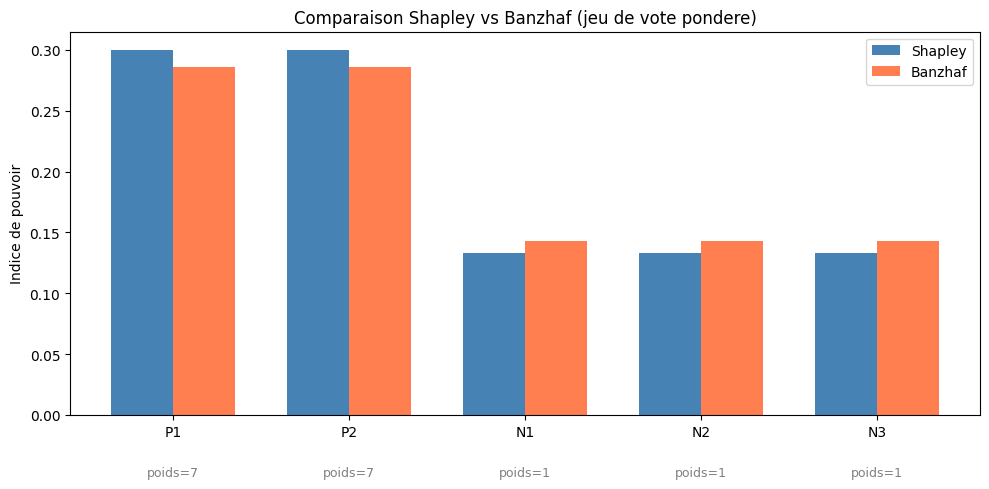

Note : Le pouvoir reel (Shapley/Banzhaf) peut differer du poids nominal!


In [10]:
# Visualisation comparative
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(labels))
width = 0.35

bars1 = ax.bar(x - width/2, shapley_un, width, label='Shapley', color='steelblue')
bars2 = ax.bar(x + width/2, banzhaf_un, width, label='Banzhaf', color='coral')

ax.set_ylabel('Indice de pouvoir')
ax.set_title('Comparaison Shapley vs Banzhaf (jeu de vote pondere)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ajouter les poids en annotation
for i, w in enumerate(weights_un):
    ax.annotate(f'poids={w}', xy=(i, 0), xytext=(i, -0.05),
                ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("Note : Le pouvoir reel (Shapley/Banzhaf) peut differer du poids nominal!")

---

## 5. Jeux Convexes : Shapley dans le Core

Un jeu est **convexe** (supermodulaire) si les contributions marginales sont croissantes. Pour les jeux convexes, la valeur de Shapley est dans le Core.

In [11]:
def is_convex(v, n):
    """Verifie si un jeu est convexe.
    
    Un jeu est convexe si pour tout S, T : v(S) + v(T) <= v(S u T) + v(S n T)
    """
    for r1 in range(n + 1):
        for S in combinations(range(n), r1):
            S = frozenset(S)
            for r2 in range(n + 1):
                for T in combinations(range(n), r2):
                    T = frozenset(T)
                    lhs = v(S) + v(T)
                    rhs = v(S | T) + v(S & T)
                    if lhs > rhs + 1e-10:  # Tolerance numerique
                        return False
    return True

# Test sur le jeu de gants
print("TEST DE CONVEXITE")
print("=" * 40)
print(f"Jeu de gants convexe ? {is_convex(glove_game, 3)}")
print(f"Jeu de majorite convexe ? {is_convex(majority_game_3, 3)}")

# Jeu d'unanimite (toujours convexe)
def unanimity_game(T):
    """Jeu d'unanimite : v(S) = 1 si T inclus dans S, 0 sinon."""
    def v(coalition):
        return 1 if T <= coalition else 0
    return v

v_unan = unanimity_game(frozenset({0, 1}))
print(f"Jeu d'unanimite u_{{1,2}} convexe ? {is_convex(v_unan, 3)}")

TEST DE CONVEXITE
Jeu de gants convexe ? False
Jeu de majorite convexe ? False
Jeu d'unanimite u_{1,2} convexe ? True


In [12]:
# Verification que Shapley est dans le Core pour un jeu convexe
def is_in_core(allocation, v, n):
    """Verifie si une allocation est dans le Core."""
    # Efficacite
    if abs(sum(allocation) - v(frozenset(range(n)))) > 1e-10:
        return False, "Pas efficace"
    
    # Stabilite
    for r in range(1, n):
        for S in combinations(range(n), r):
            S_set = frozenset(S)
            coalition_value = sum(allocation[i] for i in S)
            if coalition_value < v(S_set) - 1e-10:
                return False, f"Coalition {S} peut bloquer"
    
    return True, "Dans le Core"

# Jeu convexe simple
def convex_game(coalition):
    """Un jeu convexe : v(S) = |S|^2 / 9."""
    return len(coalition) ** 2 / 9

print("\nJEU CONVEXE : v(S) = |S|^2 / 9")
print("=" * 40)
print(f"Convexe ? {is_convex(convex_game, 3)}")

shapley_convex = shapley_value_exact(convex_game, 3)
print(f"\nShapley : {shapley_convex}")

in_core, msg = is_in_core(shapley_convex, convex_game, 3)
print(f"Shapley dans le Core ? {in_core} - {msg}")

# Verification du jeu de majorite (non convexe, Shapley hors Core)
print(f"\nJeu de majorite :")
in_core_maj, msg_maj = is_in_core(shapley_majority, majority_game_3, 3)
print(f"Shapley dans le Core ? {in_core_maj} - {msg_maj}")


JEU CONVEXE : v(S) = |S|^2 / 9
Convexe ? True

Shapley : [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Shapley dans le Core ? True - Dans le Core

Jeu de majorite :
Shapley dans le Core ? False - Coalition (0, 1) peut bloquer


---

## Resume

| Concept | Implementation Python |
|---------|----------------------|
| Shapley exact | `shapley_value_exact(v, n)` |
| Banzhaf | `banzhaf_index(v, n)` |
| Vote pondere | `weighted_voting_game(weights, quota)` |
| Test convexite | `is_convex(v, n)` |
| Test Core | `is_in_core(allocation, v, n)` |

**Lien avec le notebook 21 Lean** :

| Notebook 21 (Lean) | Notebook 21b (Python) |
|--------------------|----------------------|
| Axiomes de Shapley | Calcul numerique |
| Theoreme d'unicite | Verification empirique |
| Definition du Core | Test d'appartenance |
| Jeux de vote | Banzhaf et comparaison |

---

**Navigation** : [← GameTheory-21-Lean-CooperativeGames](GameTheory-21-Lean-CooperativeGames.ipynb) | [Index](GameTheory-1-Setup.ipynb) | [Fin de la serie]